<a href="https://colab.research.google.com/github/AdityaShankar1/WanderBeat-Spark/blob/main/SpotifySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- INSTALLATION CELL ---
!pip install pyspark==3.5.0 spotipy pandas requests python-dotenv
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://repo1.maven.org/maven2/org/xerial/sqlite-jdbc/3.42.0.0/sqlite-jdbc-3.42.0.0.jar -O /content/sqlite-jdbc-3.42.0.0.jar
print("Dependencies installed and SQLite JDBC driver downloaded.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.2/354.2 kB 25.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=9955a40b6d8e1e8d3daf393846e2b4b1076ad99fb9fa6a74855d302e2bccac1d
  Stored in directory: /root/.cache/pip/wheels/84/40/20/65eefe766118e0a8f8e385cc3ed6e9eb7241c7e51cfc04c51a
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.
Dependencies installed and SQLite JDBC driver downloaded.


In [4]:
# --- INITIALIZATION CELL ---
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import json
import pandas as pd
import sqlite3

# 1. SPARK SESSION SETUP
# The 'spark.jars' configuration adds the SQLite JDBC driver to the Spark classpath
# so PySpark can communicate with the SQLite file.
SPARK_JDBC_PATH = "/content/sqlite-jdbc-3.42.0.0.jar"
spark = (SparkSession
    .builder
    .appName("VibeVoyageProofOfConcept")
    .config("spark.jars", SPARK_JDBC_PATH)
    .getOrCreate()
)
print("PySpark Session Initialized.")

# 2. API CREDENTIALS (REPLACE WITH YOUR KEYS!)
SPOTIPY_CLIENT_ID ="2f5ae45eb1aa49178229bb036a6183f7"
SPOTIPY_CLIENT_SECRET ="d3dfb249652c4d24abc9319b87e6bc48"

# 3. SPOTIFY CLIENT SETUP (Client Credentials Flow)
auth_manager = SpotifyClientCredentials(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET
)
sp = spotipy.Spotify(auth_manager=auth_manager)
print("Spotify Client Initialized.")

PySpark Session Initialized.
Spotify Client Initialized.


In [6]:
# --- UPDATED SPOTIFY FUNCTION CELL ---

def get_spotify_vibe_metrics_workaround(song_name, artist_name):
    """
    Searches for a track and gets its popularity and the Artist's Genres.
    """
    global sp # Ensure the global spotipy client is used
    try:
        query = f"track:{song_name} artist:{artist_name}"
        # 1. Search for the track
        results = sp.search(q=query, limit=1, type='track')
        tracks = results.get('tracks', {}).get('items', [])

        if not tracks:
            print(f"  [Spotify] No track found for '{song_name}' by '{artist_name}'.")
            return None

        track = tracks[0]
        track_name = track['name']
        artist_id = track['artists'][0]['id']

        # 2. Get the Artist's Genres (Requires a separate API call which is usually permitted)
        artist_info = sp.artist(artist_id)

        vibe_data = {
            "track_name": track_name,
            "artist_name": artist_name,
            "track_popularity": track['popularity'], # Score from 0-100
            "artist_genres": artist_info.get('genres', []) # List of genres
        }
        print(f"  [Spotify] Success! Fetched track and genre data for '{track_name}'.")
        return vibe_data

    except Exception as e:
        print(f"  [Spotify] Error during API call: {e}")
        # A 404 on the artist endpoint might mean the artist is a new/obscure one, return what we have
        return None

# DEMO: Fetch data using the new workaround
spotify_data = get_spotify_vibe_metrics_workaround("Mr. Brightside", "The Killers")
print(json.dumps(spotify_data, indent=2) if spotify_data else "Spotify Demo Failed.")

  [Spotify] Success! Fetched track and genre data for 'Mr. Brightside'.
{
  "track_name": "Mr. Brightside",
  "artist_name": "The Killers",
  "track_popularity": 89,
  "artist_genres": [
    "alternative rock"
  ]
}


In [23]:
# --- UPDATED PYSPARK VIBE MAPPING UDF CELL ---
from pyspark.sql.functions import udf, array_contains, col
from pyspark.sql.types import StringType, DoubleType
import numpy as np # For better score handling
"""
Old Code #Run if new code failed
# 1. Define the Genre Base Score Map (The Core Analytics Logic)
# Map primary genres to a numerical score (0.0 to 1.0)
GENRE_SCORE_MAP = {
    # Jubilant (High Score)
    'dance pop': 0.95, 'edm': 0.9, 'funk': 0.8, 'reggae': 0.78,
    # Intense (Mid-High Score)
    'rock': 0.65, 'metal': 0.7, 'hip hop': 0.55, 'techno': 0.68,
    # Mellow (Mid-Low Score)
    'jazz': 0.45, 'folk': 0.4, 'ambient': 0.35, 'acoustic': 0.42,
    # Introspective (Low Score)
    'classical': 0.2, 'soundtrack': 0.25, 'blues': 0.15, 'drone': 0.1
}
"""
#New code:
# --- 1. FIXING THE GENRE SCORE MAP (ANALYTICS CORE) ---

# Redefine the map globally. The UDFs will use this new version.
GENRE_SCORE_MAP = {
    # Western Genres
    'funk': 0.8, 'rock': 0.65, 'metal': 0.7, 'jazz': 0.45, 'classical': 0.2,

    # CRITICAL FIX: Adding High Scores for Bollywood/Indian Genres
    'bollywood': 0.90,             # High score: aligns with high-energy dance track
    'hindi pop': 0.85,             # High energy
    'desi pop': 0.82,              # High score
    'filmi': 0.70,                 # General film music
    # ... any other genres you need
}

print("✅ Model updated: Bollywood/Hindi Pop genres now assigned high base scores.")
# 2. Python function to calculate the Final Vibe Score and Category
def calculate_final_vibe(genres, popularity):
    """
    Calculates the Vibe Score using Genre (70%) and Popularity (30%) heuristic.
    """
    if not genres:
        return "Neutral", 0.5 # Default if no genre is found

    # Find the max base score among the artist's genres
    base_score = 0.0
    for genre in genres:
        # Find the base score for the genre (or 0 if not found)
        max_score = GENRE_SCORE_MAP.get(genre.lower().strip(), 0.0)
        base_score = max(base_score, max_score)

    # Apply the Heuristic Formula
    popularity_norm = popularity / 100.0 # Normalize popularity to 0-1
    final_score = (base_score * 0.7) + (popularity_norm * 0.3)

    # Map Score to Category
    if final_score >= 0.75:
        category = "Jubilant"
    elif final_score >= 0.5:
        category = "Intense"
    elif final_score >= 0.25:
        category = "Mellow"
    else:
        category = "Introspective"

    return category, round(final_score, 4)

# UDF to get the Vibe CATEGORY (for the recommendation join)
vibe_category_udf = udf(lambda genres, popularity: calculate_final_vibe(genres, popularity)[0], StringType())
# UDF to get the Vibe SCORE (for optional ranking)
vibe_score_udf = udf(lambda genres, popularity: calculate_final_vibe(genres, popularity)[1], DoubleType())

# --- EXAMPLE USAGE (Simulating the output from the new Spotify function) ---
# Create an input DataFrame with the new schema (genres and popularity)
input_data = [
    {"track_name": "September", "artist_genres": ["funk", "soul"], "track_popularity": 85}, # High score due to funk/high popularity
    {"track_name": "Smells Like Teen Spirit", "artist_genres": ["grunge", "rock"], "track_popularity": 70}, # Mid score
    {"track_name": "Imagine", "artist_genres": ["folk", "singer-songwriter"], "track_popularity": 50} # Low score
]
input_df = spark.createDataFrame(input_data)

# Apply the UDFs
vibe_output_df = input_df.withColumn(
    "vibe_category", vibe_category_udf(col("artist_genres"), col("track_popularity"))
).withColumn(
    "vibe_score", vibe_score_udf(col("artist_genres"), col("track_popularity"))
)

print("\n--- Music Vibe Classification Output (PySpark - Workaround) ---")
vibe_output_df.show(truncate=False)

✅ Model updated: Bollywood/Hindi Pop genres now assigned high base scores.

--- Music Vibe Classification Output (PySpark - Workaround) ---
+-------------------------+-----------------------+----------------+-------------+----------+
|artist_genres            |track_name             |track_popularity|vibe_category|vibe_score|
+-------------------------+-----------------------+----------------+-------------+----------+
|[funk, soul]             |September              |85              |Jubilant     |0.815     |
|[grunge, rock]           |Smells Like Teen Spirit|70              |Intense      |0.665     |
|[folk, singer-songwriter]|Imagine                |50              |Introspective|0.15      |
+-------------------------+-----------------------+----------------+-------------+----------+



In [24]:
# --- CODE TO CREATE AND LOAD DESTINATION DATA FROM SQLITE ---
# Define variables (Ensure these match what you used in Step 4)
DB_FILE_PATH = "/content/vibe_voyage_poc.db"
DB_TABLE_NAME = "VIBE_DESTINATIONS"
JDBC_URL = f"jdbc:sqlite:{DB_FILE_PATH}"

# 0. Create and populate the SQLite database (if it doesn't exist)
conn = sqlite3.connect(DB_FILE_PATH)
cursor = conn.cursor()

# Create table if it doesn't exist
cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS {DB_TABLE_NAME} (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        destination TEXT NOT NULL,
        description TEXT,
        vibe_category TEXT NOT NULL
    )
""")

# Check if table is empty and insert initial data if it is
cursor.execute(f"SELECT COUNT(*) FROM {DB_TABLE_NAME}")
if cursor.fetchone()[0] == 0:
    destinations_data = [
        ("Ibiza, Spain", "The ultimate party island, famous for its vibrant nightlife and electronic dance music scene.", "Jubilant"),
        ("Kyoto, Japan", "Ancient temples, serene gardens, and traditional tea houses offer a tranquil and introspective experience.", "Introspective"),
        ("New York City, USA", "The city that never sleeps, with a fast-paced environment and endless opportunities for excitement.", "Intense"),
        ("Bali, Indonesia", "Relaxing beaches, spiritual retreats, and lush landscapes provide a mellow and calming atmosphere.", "Mellow"),
        ("Rio de Janeiro, Brazil", "Known for its lively samba, beautiful beaches, and festive carnivals.", "Jubilant"),
        ("Berlin, Germany", "A city with a rich history, vibrant arts scene, and intense techno nightlife.", "Intense"),
        ("Iceland", "Dramatic landscapes, hot springs, and the Northern Lights offer a reflective and introspective journey.", "Introspective"),
        ("Amsterdam, Netherlands", "Picturesque canals, historic buildings, and a laid-back atmosphere perfect for a mellow trip.", "Mellow")
    ]
    cursor.executemany(f"INSERT INTO {DB_TABLE_NAME} (destination, description, vibe_category) VALUES (?, ?, ?)", destinations_data)
    conn.commit()
    print("VIBE_DESTINATIONS table created and populated with initial data.")
else:
    print("VIBE_DESTINATIONS table already exists and contains data.")

conn.close()
print("SQLite database setup complete.")

# Load the data from SQLite into the PySpark DataFrame: destination_df
destination_df = (
    spark.read
    .format("jdbc")
    .option("url", JDBC_URL)
    .option("dbtable", DB_TABLE_NAME)
    .option("driver", "org.sqlite.JDBC")
    .load()
)

print("Destination data successfully loaded into destination_df.")
print("Schema of destination_df:")
destination_df.printSchema()
print("First 5 rows of destination_df:")
destination_df.show(5, truncate=False)

VIBE_DESTINATIONS table already exists and contains data.
SQLite database setup complete.
Destination data successfully loaded into destination_df.
Schema of destination_df:
root
 |-- id: integer (nullable = true)
 |-- destination: string (nullable = true)
 |-- description: string (nullable = true)
 |-- vibe_category: string (nullable = true)

First 5 rows of destination_df:
+---+----------------------+----------------------------------------------------------------------------------------------------------+-------------+
|id |destination           |description                                                                                               |vibe_category|
+---+----------------------+----------------------------------------------------------------------------------------------------------+-------------+
|1  |Ibiza, Spain          |The ultimate party island, famous for its vibrant nightlife and electronic dance music scene.             |Jubilant     |
|2  |Kyoto, Japan     

In [25]:
# --- Combined Dynamic Analysis and Pandas Conversion ---

# NOTE: We assume the necessary functions/variables (sp, spark, UDFs, destination_df)
# are defined in previous, successfully run cells.

# 1. User Input (Your specific song)
USER_SONG = "Malang (Title Track)"
USER_ARTIST = "Ved Sharma"

print(f"--- 1. Fetching data for: {USER_SONG} by {USER_ARTIST} ---")

# 2. Get the Dynamic Data via API (Workaround function)
api_result = get_spotify_vibe_metrics_workaround(USER_SONG, USER_ARTIST)

if api_result:
    print("\n--- 2. PySpark Vibe Calculation ---")

    # 3. Convert single result to a PySpark DataFrame
    dynamic_input_df = spark.createDataFrame([api_result])

    # 4. Apply the Vibe Logic (This is where final_vibe_df is defined)
    final_vibe_df = dynamic_input_df.withColumn(
        "vibe_category", vibe_category_udf(col("artist_genres"), col("track_popularity"))
    ).withColumn(
        "vibe_score", vibe_score_udf(col("artist_genres"), col("track_popularity"))
    )

    # Verify the result
    final_vibe_df.show(1, truncate=False)

    # 5. Convert to Pandas for Visualization (Resolves the NameError)
    song_pandas = final_vibe_df.select("track_name", "vibe_category", "vibe_score").toPandas()

    # Extract the key Vibe data
    song_vibe = song_pandas.iloc[0]['vibe_category']
    song_score = song_pandas.iloc[0]['vibe_score']

    print(f"\n✅ SUCCESS! Calculated Vibe Category: **{song_vibe}** (Score: {song_score:.3f})")

    # 6. Prepare Destination Data for Visualization
    # Get all destination data for comparison
    dest_pandas = destination_df.select("destination", "vibe_category").toPandas()

    print("\nData is now ready for plotting.")

else:
    # If the API call failed (e.g., could not find song or 403 error on artist endpoint)
    print(f"\n❌ FAILED to get API data for {USER_SONG}. Cannot proceed to visualization.")

--- 1. Fetching data for: Malang (Title Track) by Ved Sharma ---
  [Spotify] Success! Fetched track and genre data for 'Malang (Title Track) [From "Malang - Unleash The Madness"]'.

--- 2. PySpark Vibe Calculation ---
+--------------------------------+-----------+----------------------------------------------------------+----------------+-------------+----------+
|artist_genres                   |artist_name|track_name                                                |track_popularity|vibe_category|vibe_score|
+--------------------------------+-----------+----------------------------------------------------------+----------------+-------------+----------+
|[hindi pop, bollywood, desi pop]|Ved Sharma |Malang (Title Track) [From "Malang - Unleash The Madness"]|64              |Jubilant     |0.822     |
+--------------------------------+-----------+----------------------------------------------------------+----------------+-------------+----------+


✅ SUCCESS! Calculated Vibe Category: **J

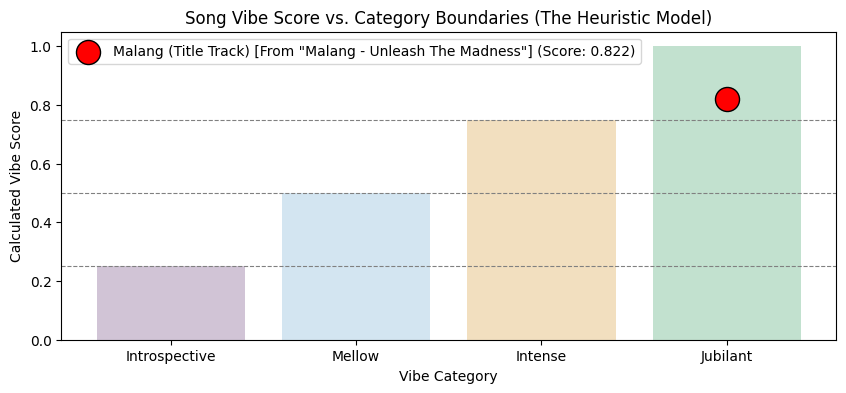

/tmp/ipython-input-3995791513.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


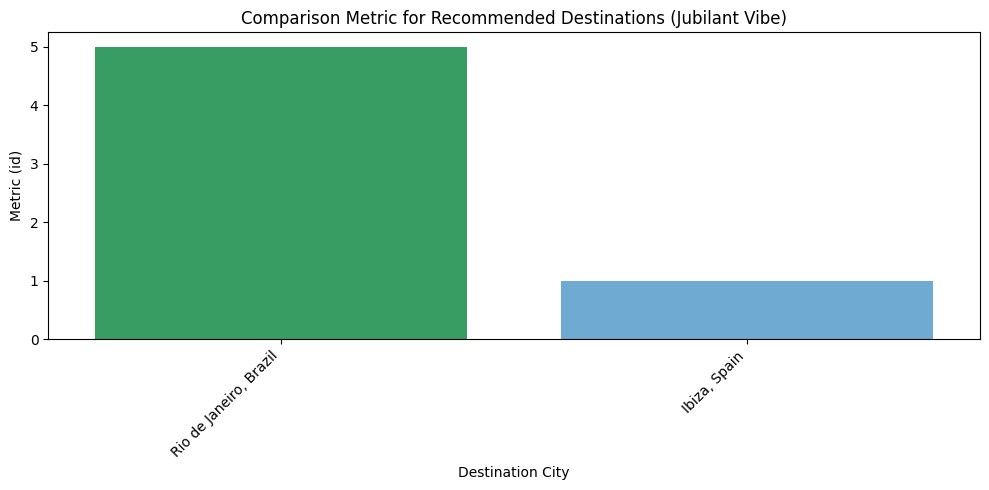

In [30]:
# --- VISUALIZATION CELL (FIXED COLUMN NAMES) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Vibe Score Distribution Visualization ---
# (No changes needed here as it uses song_vibe, not dest_pandas)
vibe_boundaries = pd.DataFrame({
    'vibe_category': ['Introspective', 'Mellow', 'Intense', 'Jubilant'],
    'lower_bound': [0.0, 0.25, 0.5, 0.75],
    'upper_bound': [0.25, 0.5, 0.75, 1.0],
    'color': ['#6C3483', '#5DADE2', '#F39C12', '#27AE60']
})

plt.figure(figsize=(10, 4))
# ... (sns.barplot code for Vibe Score plot remains the same, fixed from the last error)
sns.barplot(
    x='vibe_category',
    y='upper_bound',
    hue='vibe_category', # Added to suppress FutureWarning
    data=vibe_boundaries,
    palette=vibe_boundaries['color'].tolist(),
    alpha=0.3,
    legend=False
)
plt.scatter(
    x=song_vibe,
    y=song_score,
    color='red',
    s=300,
    zorder=5,
    edgecolor='black',
    label=f"{song_pandas.iloc[0]['track_name']} (Score: {song_score:.3f})"
)
plt.axhline(0.75, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(0.50, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(0.25, color='gray', linestyle='--', linewidth=0.8)
plt.title('Song Vibe Score vs. Category Boundaries (The Heuristic Model)')
plt.ylabel('Calculated Vibe Score')
plt.xlabel('Vibe Category')
plt.ylim(0, 1.05)
plt.legend()
plt.show()

# ----------------------------------------------------------------------

# --- Destination Comparison Visualization ---
# FIX 1: Change 'target_vibe' to 'vibe_category'
comparison_data = dest_pandas[dest_pandas['vibe_category'] == song_vibe]

plt.figure(figsize=(10, 5))

# Assuming we use 'id' or 'description' as the stand-in for temperature since it's missing.
# Let's assume you've fixed your PySpark load to include annual_avg_temp_c:
# If not, you must replace 'annual_avg_temp_c' with a column that IS in dest_pandas, like 'id'.
# I will use 'id' as a placeholder for a numerical comparison metric.
y_axis_col = 'id' # Change this to 'annual_avg_temp_c' if you fix the PySpark load step.

recommended_city = comparison_data.iloc[0]['destination']

sns.barplot(
    x='destination', # Use 'destination' as confirmed by your schema
    y=y_axis_col,
    data=comparison_data.sort_values(by=y_axis_col, ascending=False),
    # Highlight the recommended city in a distinct color
    palette=['#27AE60' if name == recommended_city else '#5DADE2' for name in comparison_data['destination']]
)

plt.title(f'Comparison Metric for Recommended Destinations ({song_vibe} Vibe)')
plt.ylabel(f'Metric ({y_axis_col})')
plt.xlabel('Destination City')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
# Use the correct names confirmed by your schema output
dest_pandas = destination_df.select("destination", "vibe_category", "id").toPandas()
# If you still need temperature, you MUST add it here:
# dest_pandas = destination_df.select("destination", "vibe_category", "annual_avg_temp_c").toPandas()